In [1]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson, gamma, expon, binom, norm
from utils import *

sns.set_style("whitegrid")

# Revisting Coin problem

0.56
[0.51 0.61]


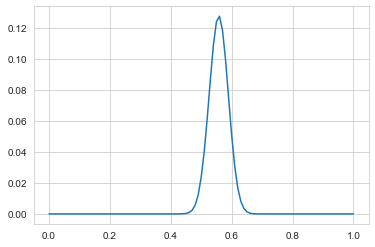

In [2]:
# data
k, n = 140, 250
prior = make_tri_dist(101)
likelihood = binom.pmf(k=k, n=n, p=prior.index.values)
posterior = normalize_dist(prior * likelihood)

print(posterior.idxmax())
print(credible_interval(posterior, p=0.1))
posterior.plot()
plt.show()

In [3]:
# unfair uniform distribution
# hypothesis - in a uniform distribution, anything other than 0.5 is biased
hypos = make_uniform_dist(np.linspace(0,1,101))
hypos.loc[0.50] = 0
hypos = normalize_dist(hypos)

likelihood = binom.pmf(k=k, n=n, p=hypos.index.values)

p_biased = np.sum(hypos * likelihood)  # E[likelihood] d(hypos)
p_fair = binom.pmf(k, n, p=0.5)

K = p_fair / p_biased
print('Fair vs Biased K = {:.2f}'.format(K))

Fair vs Biased K = 2.14


In [4]:
# unfair triangular distribution
# hypothesis - in a triangular distribution, anything other than 0.5 is biased
hypos = make_tri_dist(np.linspace(0,1,101))
hypos.loc[0.5] = 0
hypos = normalize_dist(hypos)

likelihood = binom.pmf(k=k, n=n, p=hypos.index.values)

p_biased = np.sum(hypos * likelihood)  # E[likelihood] d(hypos)
p_fair = binom.pmf(k, n, p=0.5)

K = p_fair / p_biased
print('Fair vs Biased K = {:.2f}'.format(K))

Fair vs Biased K = 1.20


# Bayesian Bandit Problem

In [2]:
def plot(beliefs):
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 6))
    plt.tight_layout()

    _i, _j = 0, 0
    _nrow = axes.shape
    for i, d in enumerate(beliefs):
        ax = axes[_i,_j]
        d.plot(ax=ax, label=f"Machine {i}")

        if _j == 0:
            ax.set_ylabel('PDF')
        
        if _i == _nrow[0]-1:
            ax.set_xlabel('P[Winning]')

        _j += 1
        if _j+1 > _nrow[1]:
            _j = 0
            _i += 1

        if _i+1 > _nrow[0]:
            _i = 0

        ax.legend()
    plt.show()

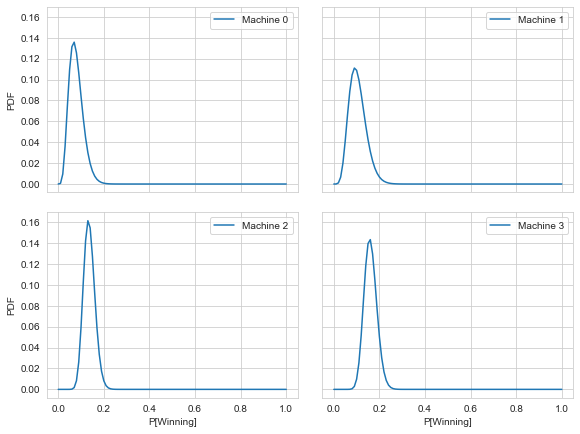

In [23]:
from collections import Counter

def play(i):
    counter[i] += 1
    p = actual_prob[i]
    if np.random.random() < p:
        return 'W'
    else:
        return 'L'

def update(i, data):
    posterior = update_prior(beliefs[i], likelihood[outcome])
    beliefs[i] = posterior

def choose(beliefs):
    # thomas sampling
    # choose random proportionally to the posterior prob (the prob of being the best)
    ps = [np.random.choice(b.index.values, p=b.values) for b in beliefs]
    return np.argmax(ps)

N = 4
hypos = np.linspace(0,1,101)
beliefs = [make_uniform_dist(hypos)] * N
likelihood = {'W': hypos, 'L': 1-hypos}
actual_prob = np.array([0.1, 0.125, 0.15, 0.175])
counter = Counter()

for t in range(500):
    i = choose(beliefs)
    outcome = play(i)
    update(i, outcome)

plot(beliefs)

In [24]:
d = []
for i, b in enumerate(beliefs):
    _d = (
        actual_prob[i],
        np.round((b.index.values * b.values).sum(), 3),
        np.round(credible_interval(b, p=0.1), 3),
        counter[i],
    )
    d.append(_d)

pd.DataFrame(d, columns=['Actual P(win)', 'Posterior Mean', 'CI 90%', 'Times Played'])

,Actual P(win),Posterior Mean,CI 90%,Times Played
0,0.100,0.079,"[0.04, 0.13]",74
1,0.125,0.104,"[0.05, 0.17]",65
2,0.150,0.136,"[0.1, 0.18]",189
3,0.175,0.161,"[0.12, 0.21]",172
